In [4]:
import numpy as np
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from matplotlib import image
import glob
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from skimage import data, io
from skimage.feature import greycomatrix, greycoprops
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve
from sklearn.datasets import load_iris
from sklearn.linear_model import Ridge
from sklearn import svm
from sklearn.tree import export_text

In [18]:
# load image as pixel array
#data = image.imread('metal_moderate_001_new.jpg')

directoryGlass = 'C:/Users/Nida/Desktop/Lectures/Pattern/Final/FMD/image/glass/'
directoryMetal = 'C:/Users/Nida/Desktop/Lectures/Pattern/Final/FMD/image/metal/'
directoryGlassMask = 'C:/Users/Nida/Desktop/Lectures/Pattern/Final/FMD/mask/glass/'
directoryMetalMask = 'C:/Users/Nida/Desktop/Lectures/Pattern/Final/FMD/mask/metal/'

generalDataX = []
generalDataY = [] # 0 for glass, 1 for metal
generalDataMask = [] # Mask images 

# read to-be-classified images 
for filename in glob.glob(directoryGlass+'*.jpg'):
    generalDataX.append(np.array(cv2.imread(filename, cv2.IMREAD_GRAYSCALE)))
    generalDataY.append("glass")#glass-0
for filename in glob.glob(directoryMetal+'*.jpg'):
    generalDataX.append(np.array(cv2.imread(filename, cv2.IMREAD_GRAYSCALE)))
    generalDataY.append("metal")#metal-1
# read mask images
for filename in glob.glob(directoryGlassMask+'*.jpg'):
    generalDataMask.append(np.array(cv2.imread(filename, cv2.IMREAD_GRAYSCALE)))
for filename in glob.glob(directoryMetalMask+'*.jpg'):
    generalDataMask.append(np.array(cv2.imread(filename, cv2.IMREAD_GRAYSCALE)))

maskedDataX = []
for i in range(len(generalDataX)):
    # Mask input image with binary mask
    maskedDataX.append(np.array(cv2.bitwise_and(generalDataX[i], generalDataMask[i])))
    #cv2.imshow('image', generalDataX[i])
    #cv2.imshow('mask', generalDataMask[i])
    #cv2.imshow('result', maskedDataX[i])
    #cv2.waitKey()

glcmFeatureX = []

for i in maskedDataX:
    glcm = greycomatrix(i, distances=[5], angles=[0], levels=256,symmetric=True, normed=True)#greycomatrix(i, distances=[1, 2], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],symmetric=True,normed=False)
    glcm_br = glcm[1:, 1:, :, :]# get rid of 0(black) pixels
    glcm_br_norm = np.true_divide(glcm_br, glcm_br.sum(axis=(0, 1)))
    props = ['homogeneity', 'energy']#, 'contrast', 'correlation'
    feats_br = np.hstack([greycoprops(glcm_br_norm, p).ravel() for p in props])
    glcmFeatureX.append(feats_br)
#numImages = np.array(maskedDataX).shape[0]
#generalDataXFlattened = np.array([maskedDataX[i].flatten() for i in range(0,numImages)])

# split dataset for training and testing
print(glcmFeatureX[0])
X_train, X_test, y_train, y_test = train_test_split(glcmFeatureX, generalDataY, test_size=0.20, random_state=42)
print(len(X_train), len(X_test), len(y_train), len(y_test))

[0.2819742  0.03777502]
160 40 160 40


In [30]:
clf = RandomForestClassifier(max_depth=40, random_state=0)
print(features)
clf.fit(X_train, y_train)
#clf.fit(X_reduced, y_train)
print("Cross validation in progress...")
#X_test_reduced = pca.transform(X_test)
scores = cross_val_score(clf,glcmFeatureX,generalDataY , cv=5)#
#scores = cross_val_score(clf, X_test_reduced, y_test, cv=5)
print("Scores : ",scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print(export_text(clf.estimators_[0], spacing=3, decimals=3,feature_names= ['homogeneity', 'energy' ]))

[0.2819742  0.03777502]
Cross validation in progress...
Scores :  [0.6   0.675 0.65  0.65  0.6  ]
0.64 accuracy with a standard deviation of 0.03
|--- homogeneity <= 0.160
|   |--- energy <= 0.009
|   |   |--- homogeneity <= 0.059
|   |   |   |--- energy <= 0.007
|   |   |   |   |--- class: 0.0
|   |   |   |--- energy >  0.007
|   |   |   |   |--- class: 1.0
|   |   |--- homogeneity >  0.059
|   |   |   |--- class: 0.0
|   |--- energy >  0.009
|   |   |--- homogeneity <= 0.098
|   |   |   |--- energy <= 0.017
|   |   |   |   |--- energy <= 0.014
|   |   |   |   |   |--- energy <= 0.010
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- energy >  0.010
|   |   |   |   |   |   |--- energy <= 0.010
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- energy >  0.010
|   |   |   |   |   |   |   |--- homogeneity <= 0.064
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- homogeneity >  0.064
|   |   |   |   |   |   |   |   |---

|options|scores|accuracy|sdv|
|:-----:|:---:|:---:|:-----:|
|contrast-dissimilarity| 0.3571 0.3846 0.3846 0.5385 0.4615 | 0.43 | 0.07|
||0.625 0.525 0.575 0.5   0.425|0.53|0.07|
|contrast-homogeneity| 0.3571 0.5385 0.6154 0.6923 0.4615 |0.53|  0.12| 
||0.6   0.575 0.625 0.5   0.625|0.58|0.05|
|contrast-ASM| 0.675 0.6   0.55  0.675 0.55 |0.61|  0.06|
||0.6   0.725 0.65  0.525 0.6|0.62|0.07|
|contrast-energy| 0.575 0.525 0.55  0.6   0.475 |0.55|  0.04|
||0.6   0.725 0.675 0.525 0.6|0.62|0.07|
|contrast-correlation| 0.2143 0.3846 0.3846 0.7692 0.4615 |0.44|  0.18| 
||0.725 0.575 0.625 0.475 0.475|0.57|0.09|
|dissimilarity-homogeneity| 0.6   0.625 0.55  0.725 0.575 |0.61|  0.06| 
||0.525 0.525 0.675 0.55  0.6|0.58|0.06|
|dissimilarity-ASM| 0.6   0.55  0.55  0.625 0.5   |0.57|  0.04| 
||0.575 0.65  0.75  0.6   0.625|0.64|0.06|
|dissimilarity-energy| 0.6   0.525 0.575 0.625 0.5   |0.57|  0.05| 
||0.575 0.675 0.75  0.6   0.625|0.65|0.06|
|dissimilarity-correlation| 0.625 0.625 0.6   0.525 0.6   |0.59|  0.04| 
||0.675 0.5   0.675 0.6   0.6|0.61|0.06|
|homogeneity-ASM| 0.65  0.575 0.625 0.625 0.525 |0.60|  0.04| 
||0.6   0.675 0.675 0.65  0.6 |0.64|0.03|
|homogeneity-energy| 0.625 0.575 0.625 0.675 0.525 |0.60|  0.05| 
||0.6   0.675 0.65  0.65  0.6|0.64|0.03|
|homogeneity-correlation| 0.5   0.625 0.7   0.6   0.475 |0.58|  0.08| 
||0.475 0.525 0.5   0.4   0.5|0.48|0.04|
|ASM-energy| 0.475 0.475 0.55  0.625 0.55  |0.53|  0.06| 
||0.375 0.725 0.6   0.5   0.55|0.55|0.12|
|ASM-correlation| 0.6  0.55 0.55 0.65 0.5  |0.57|  0.05| 
||0.55  0.575 0.6   0.525 0.525|0.55|0.03|
|energy-correlation| 0.625 0.55  0.525 0.65  0.5   |0.57|  0.06| 
||0.55  0.6   0.6   0.575 0.55|0.57|0.02|
|contrast| 0.55  0.45  0.525 0.55  0.525 |0.52|  0.04| 
||0.55  0.6   0.6   0.525 0.5 |0.55|0.04|
|dissimilarity| 0.7   0.55  0.475 0.5   0.6   |0.57|  0.08|
||0.375 0.525 0.65  0.525 0.5|0.52|0.09|
|homogeneity| 0.5   0.6   0.7   0.675 0.5   |0.59|  0.08| 
||0.525 0.55  0.55  0.5   0.625|0.55|0.04|
|ASM| 0.55  0.45  0.575 0.6   0.45  |0.53|  0.06| 
||0.375 0.725 0.6   0.5   0.55|0.55|0.12|
|energy| 0.525 0.45  0.55  0.6   0.5   |0.53|  0.05| 
||0.375 0.725 0.6   0.5   0.55|0.55|0.12|
|correlation| 0.575 0.525 0.5   0.525 0.525 |0.53|  0.02| 
||0.525 0.5   0.55  0.525 0.4|0.50|0.05|

In [87]:
neigh = KNeighborsClassifier(n_neighbors=16)
#neigh.fit(X_train, y_train)
scores = cross_val_score(neigh, X_test, y_test, cv=5)#cross_val_score(clf, X_test_reduced, y_test, cv=5)
print("Scores : ",scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Scores :  [0.5   0.5   0.5   0.5   0.625]
0.53 accuracy with a standard deviation of 0.05


In [88]:
clf = svm.SVC()
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_test, y_test, cv=5)#cross_val_score(clf, X_test_reduced, y_test, cv=5)
print("Scores : ",scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Scores :  [0.75  0.625 0.625 0.75  0.75 ]
0.70 accuracy with a standard deviation of 0.06


In [3]:
def plotGraph(X_reduced, whichPrin):
    #1st and 2nd principal graphic plot
    X_reduced_sub = np.array([X_reduced[:,0] , X_reduced[:,whichPrin]]).T
    new_coordinates = np.vstack((X_reduced_sub.T, y_train)).T
    dataframe = pd.DataFrame(data=new_coordinates, columns=('1st_principal', str(whichPrin+1)+'._principal', 'label'))
    print(dataframe.head())
    sn.FacetGrid(dataframe, hue='label', size=6).map(plt.scatter, '1st_principal', str(whichPrin+1)+'._principal').add_legend()
    plt.show()

   1st_principal  2._principal  label
0     481.996634   -121.283193    0.0
1    2195.391132     40.720211    1.0
2    -357.875112    -79.313794    0.0
3    -960.441541     21.854487    1.0
4   -1075.396979     -2.525226    0.0
C:\Users\Nida\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


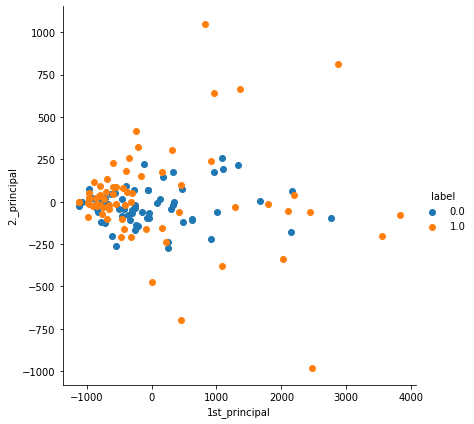

In [101]:
kpca = KernelPCA(n_components=16, kernel="poly")
kpca.fit(X_train)
X_reduced = pca.transform(X_train)
plotGraph(X_reduced, 1)

   1st_principal  2._principal  label
0     481.996634   -121.283193    0.0
1    2195.391132     40.720211    1.0
2    -357.875112    -79.313794    0.0
3    -960.441541     21.854487    1.0
4   -1075.396979     -2.525226    0.0
C:\Users\Nida\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


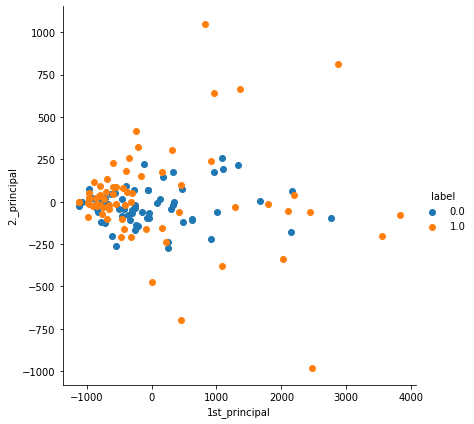

In [98]:
pca = PCA(n_components=16)
pca.fit(X_train)
X_reduced = pca.transform(X_train)
plotGraph(X_reduced, 1)